In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, BatchNormalization,Dropout,Activation
import matplotlib.pyplot as plt
from keras import callbacks
import numpy as np
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


In [3]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir -p ~/.kaggle

# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# ! kaggle datasets download -d 'jonathanoheix/face-expression-recognition-dataset'

In [5]:
# !unzip /content/drive/MyDrive/face-expression-recognition-dataset.zip

# Data Preprocessing / Data Augmentation

In [6]:
batch_size=32
img_size=48
# Data Augmentation
train_datagen = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=30,
                    shear_range=0.3,
                    #zoom_range=0.3,
                    width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    horizontal_flip=True,
                    validation_split=0.3)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

#datagen_val = ImageDataGenerator(rescale= 1.0/255)

train_set = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/images/images/train',
        target_size=(img_size, img_size),
        color_mode =  'grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset = 'training') 

validation_set = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/images/images/validation',
        target_size=(img_size, img_size),
        color_mode =  'grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
 

Found 20179 images belonging to 7 classes.
Found 2117 images belonging to 7 classes.


In [7]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Display generated data

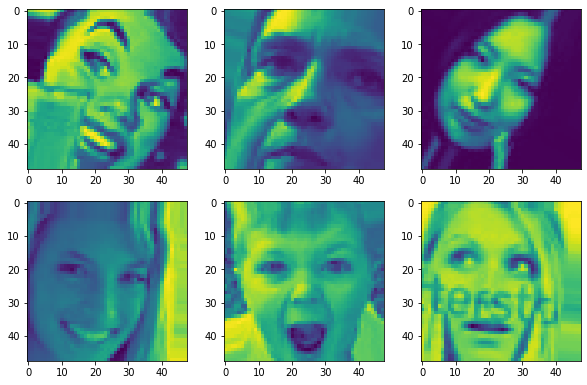

In [8]:
plt.figure(figsize= (10,10))
for i in range(1,7,1):
    img, label = train_set.next()
    # print(img.shape)   #  (128,48,48,1)
    plt.subplot(3,3,i)
    plt.imshow(img[1])
plt.show()

# CNN Architecture

In [9]:
from keras.optimizers import Adam,SGD,RMSprop
 
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same', activation='relu',input_shape = (48,48,1) ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

# Compiling the Model

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train Model

In [11]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 15

checkpoint = ModelCheckpoint("weights_model1.h5", monitor='val_acc', verbose=1, save_weights_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [checkpoint,reduce_learningrate]


history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = validation_set ,
                                validation_steps = validation_set.n//validation_set.batch_size,
                                callbacks=callbacks
                                )

Epoch 1/15
630/630 [==============================] - ETA: 0s - loss: 2.3966 - accuracy: 0.1905
Epoch 1: saving model to weights_model1.h5
630/630 [==============================] - 3699s 6s/step - loss: 2.3966 - accuracy: 0.1905 - val_loss: 1.9699 - val_accuracy: 0.2647 - lr: 1.0000e-04
Epoch 2/15
630/630 [==============================] - ETA: 0s - loss: 2.1196 - accuracy: 0.2126
Epoch 2: saving model to weights_model1.h5
630/630 [==============================] - 51s 81ms/step - loss: 2.1196 - accuracy: 0.2126 - val_loss: 1.8052 - val_accuracy: 0.2841 - lr: 1.0000e-04
Epoch 3/15
630/630 [==============================] - ETA: 0s - loss: 2.0371 - accuracy: 0.2246
Epoch 3: saving model to weights_model1.h5
630/630 [==============================] - 51s 80ms/step - loss: 2.0371 - accuracy: 0.2246 - val_loss: 1.7931 - val_accuracy: 0.2888 - lr: 1.0000e-04
Epoch 4/15
630/630 [==============================] - ETA: 0s - loss: 1.9833 - accuracy: 0.2372
Epoch 4: saving model to weights_mode

In [12]:
# Converting the model into JSON format and storing it in "model.json" file. 
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Predict one value from validation_set

(32, 48, 48, 1)
1/1 [==============================] - 0s 190ms/step
happy
class:3


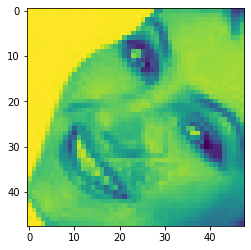

In [13]:
img, label = validation_set[0]
plt.imshow(img[10])
print(img.shape) 
y_pred = model.predict(img)
y_pred = np.argmax(y_pred, axis=1)
#print(y_pred) 
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print(classes[y_pred[10]])
print('class:'+ str(y_pred[10]))

# Comparing loss

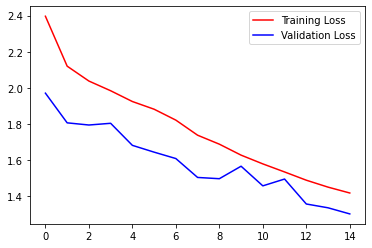

In [14]:
# Comparing loss
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

# Comparing accuracy

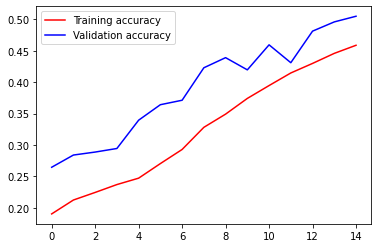

In [15]:
# Comparing accuracy
plt.plot(history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.legend()
plt.show()